In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import numpy.random as rand
import numpy.linalg as la
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import collections as mc
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

Loading Mechanical Network Deformation Solver Module


In [2]:
DIM = 3
NN = 8
node_pos = np.array([0,0,0,
                    1,0,0,
                    0,1,0,
                    1,1,0,
                    0,0,1,
                    1,0,1,
                    0,1,1,
                    1,1,1], dtype=float)
edgei = []
edgej = []
for i in range(NN):
    for j in range(i+1,NN):
        print len(edgei), i, j
        edgei.append(i)
        edgej.append(j)

edgei = np.array(edgei)
edgej = np.array(edgej)

NE = len(edgei)

L = np.array([2.0,2.0, 2.0])

eq_length = np.zeros(NE,float)
bvecij = np.zeros(DIM*NE, float)
for i in range(NE):
    posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
    posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]
    bvec = posj - posi
    bvec -= np.rint(bvec / L) * L
    bvecij[DIM*i:DIM*i+DIM] = bvec
    eq_length[i] = la.norm(bvec)

net = network.Network(DIM, NN, node_pos, NE, edgei, edgej, DIM, L)
net.setStretchInt(bvecij, eq_length, np.ones(NE, float) / eq_length)

0 0 1
1 0 2
2 0 3
3 0 4
4 0 5
5 0 6
6 0 7
7 1 2
8 1 3
9 1 4
10 1 5
11 1 6
12 1 7
13 2 3
14 2 4
15 2 5
16 2 6
17 2 7
18 3 4
19 3 5
20 3 6
21 3 7
22 4 5
23 4 6
24 4 7
25 5 6
26 5 7
27 6 7


hi


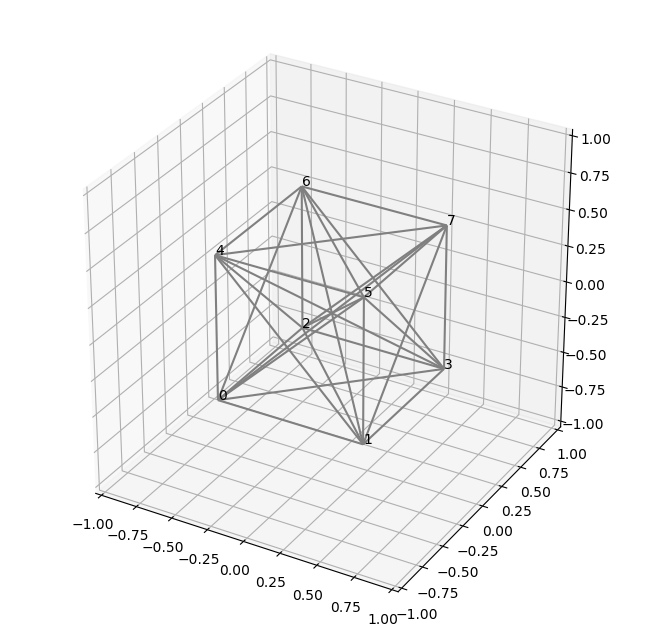

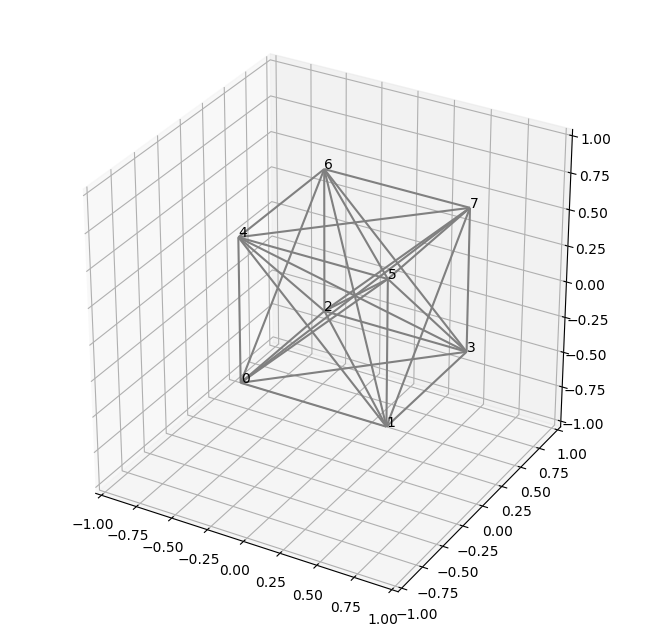

In [47]:
def plot3D(ax, net, disp=None, styles={}):
    
    DIM = 3
    
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    
    NN = net.NN
    NE = net.NE

    if disp is None:
        print "hi"
        disp = np.zeros(DIM*NN, float)
    
    
    com = 0.0
    
    for i in range(NN):
        com += node_pos[DIM*i:DIM*i+DIM]
        
    com /= NN
    
    for i in range(NN):
        node_pos[DIM*i:DIM*i+DIM] -= com
    
    edges = []
    for i in range(NE):
        
        if i in styles and 'show' in styles[i]:
            if styles[i]['show'] == False:
                continue
        
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]+disp[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]+disp[DIM*edgej[i]:DIM*edgej[i]+DIM]
        bvec = posj - posi
                
#         bvec -= np.rint(bvec / L) * L
        b = [tuple(posi),tuple(posi+bvec)]
        edges.append(b)

    colors = []
    for b in range(NE):
        
        if b in styles and 'color' in styles[b]:
            colors.append(styles[b]['color'])
        else:
            colors.append('gray')
        
    ax.add_collection3d(Line3DCollection(edges, color=colors))

    for i in range(NN):
        pos = node_pos[DIM*i:DIM*i+DIM] + disp[DIM*i:DIM*i+DIM]
        ax.text(pos[0], pos[1], pos[2], "{}".format(i))

    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)

    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
    
plot3D(ax, net)

plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plot3D(ax, net, disp=0.1*np.ones(DIM*NN, float)) 


plt.show()

In [44]:
NF = 1

inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]



inodesi[0].append(7)
inodesj[0].append(3)
istrain_bonds[0].append(21)

onodesi[0].append(4)
onodesj[0].append(0)
ostrain_bonds[0].append(3)



isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 
    
istrain = [[] for t in range(NF)]
istrain[0].append(0.5)


osvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 
    
ostrain = [[] for t in range(NF)]
ostrain[0].append(-0.5)
    
pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain), relative=False, change=False)  


K_init = np.ones(net.NE, float) / net.eq_length

tuner = talgs.TuneDiscNonlin(net, pert, meas, obj_func, K_init)

result = tuner.tune()

Initial objective function: 0.114385457341
0 Objective function: 0.087587550728 Change: -0.0267979066131 Percent: -23.4277217017 %
Removing 3
1 Objective function: 0.0707012485132 Change: -0.0168863022148 Percent: -19.2793405849 %
Removing 9
2 Objective function: 0.0358291788006 Change: -0.0348720697126 Percent: -49.32313141 %
Removing 23
3 Objective function: 0.0188966449975 Change: -0.016932533803 Percent: -47.259061943 %
Removing 26
4 Objective function: 0.00742827938319 Change: -0.0114683656143 Percent: -60.6899564226 %
Removing 18
5 Objective function: 0.00476753742946 Change: -0.00266074195374 Percent: -35.8190883309 %
Removing 17
6 Objective function: 0.0040112800205 Change: -0.000756257408961 Percent: -15.8626423002 %
Removing 27
7 Objective function: 0.00300577263455 Change: -0.00100550738595 Percent: -25.0669955927 %
Removing 21
8 Objective function: 0.00300579330555 Change: 2.06710031791e-08 Percent: 0.000687710139534 %
Stopped making progress.
Result:
{'obj_func': 0.0030057

[ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
  0.66666667  0.77777778  0.88888889  1.          1.          0.88888889
  0.77777778  0.66666667  0.55555556  0.44444444  0.33333333  0.22222222
  0.11111111  0.        ]
0
[array([ 0.])]


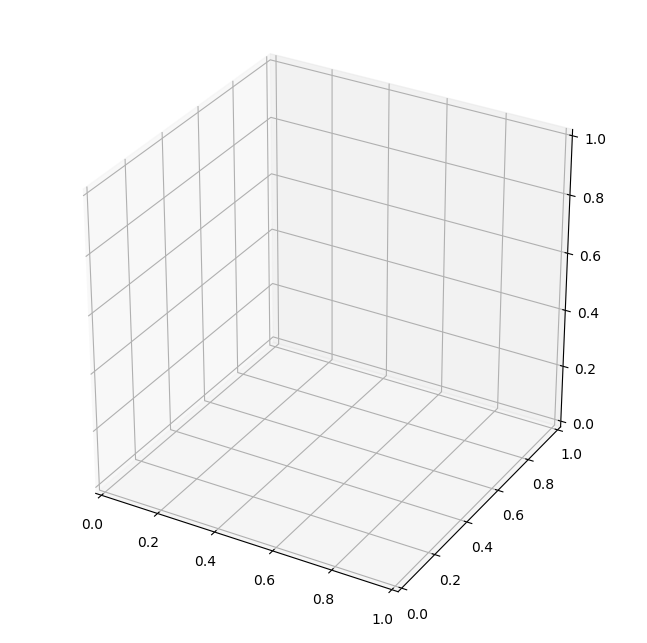

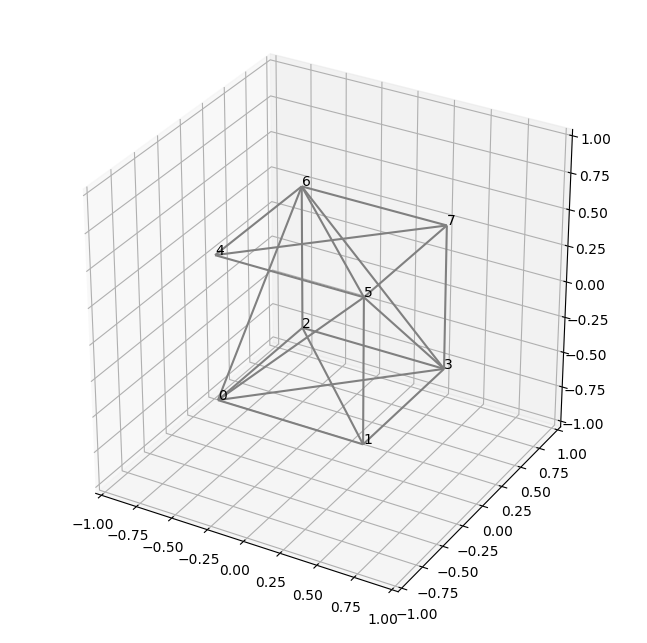

1
[array([-0.03312716])]


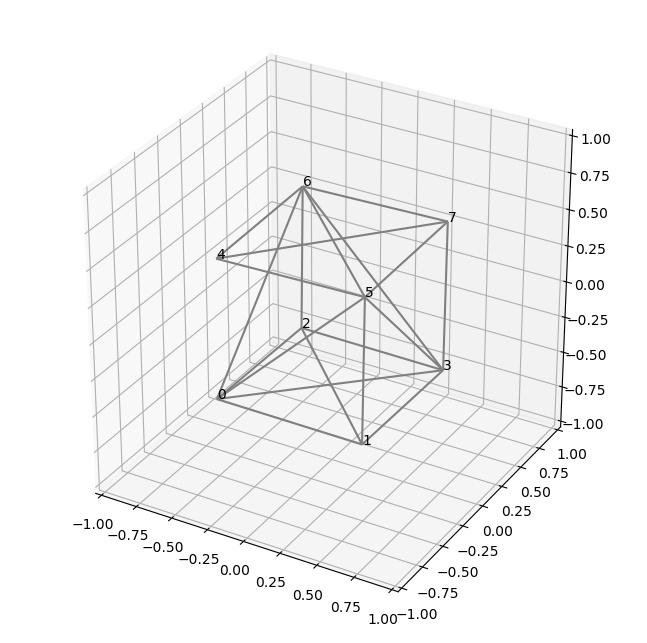

2
[array([-0.08233098])]


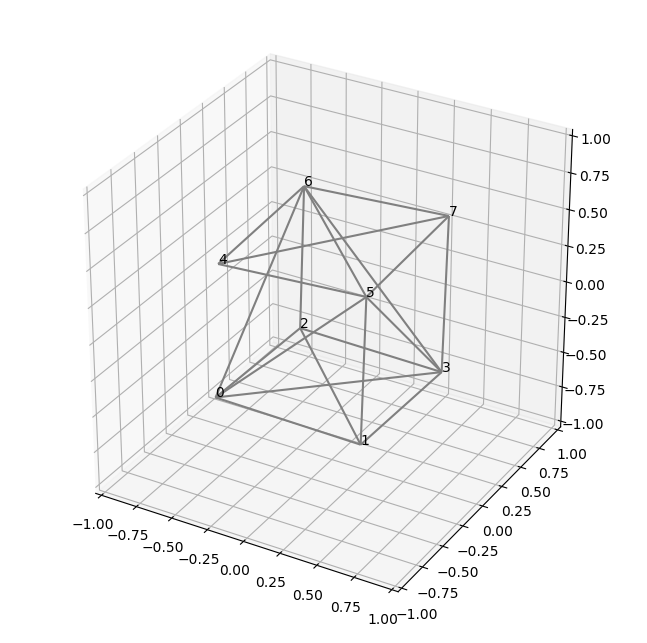

3
[array([-0.12986987])]


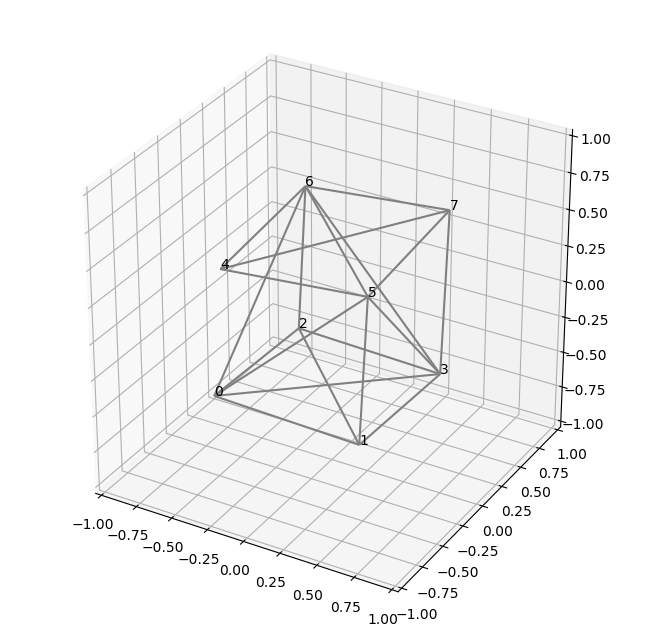

4
[array([-0.18119684])]


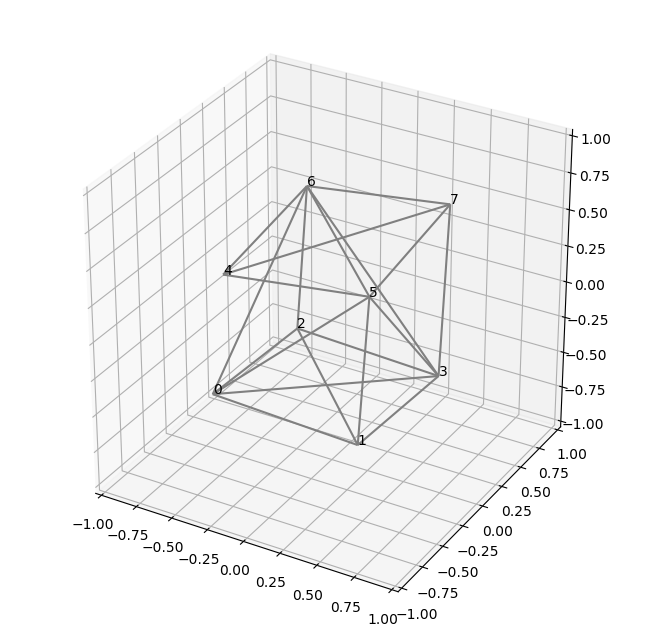

5
[array([-0.23455559])]


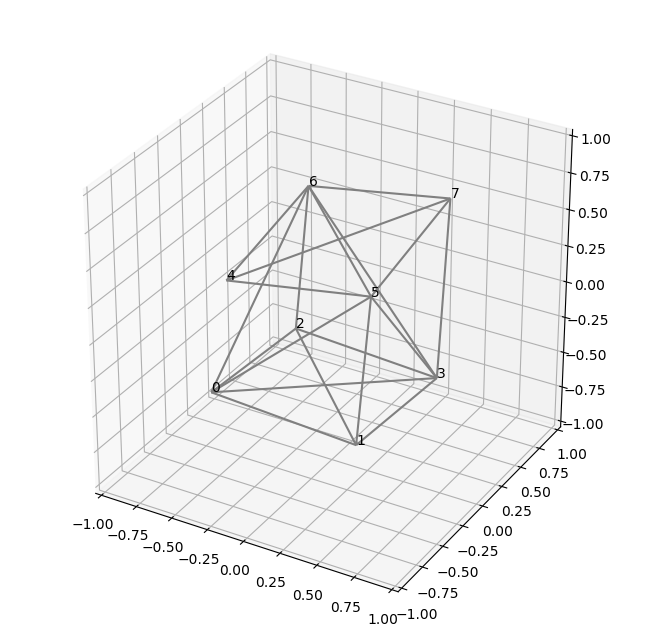

6
[array([-0.28695108])]


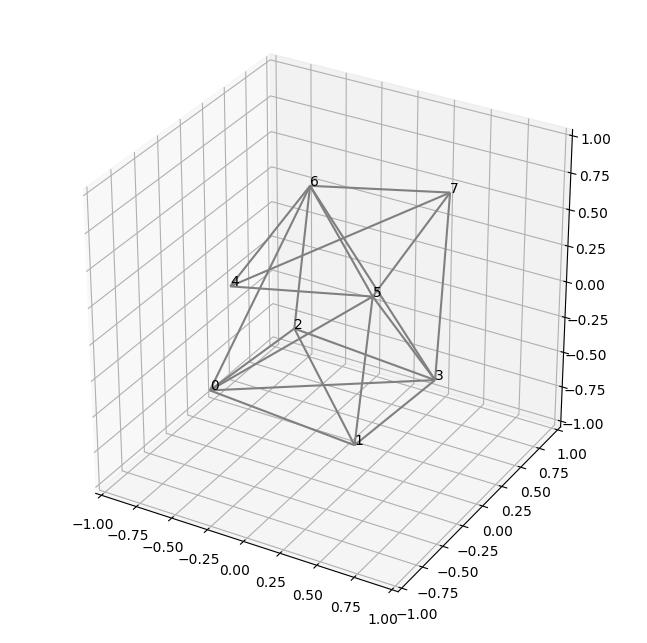

7
[array([-0.33561251])]


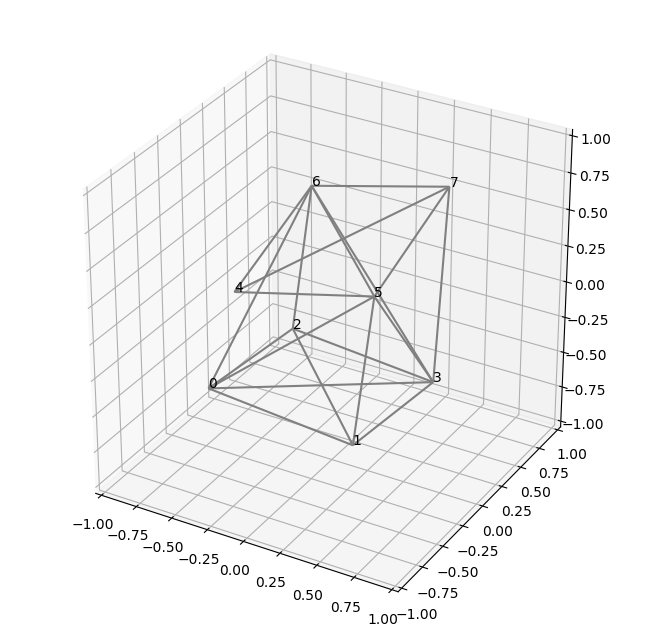

8
[array([-0.38098636])]


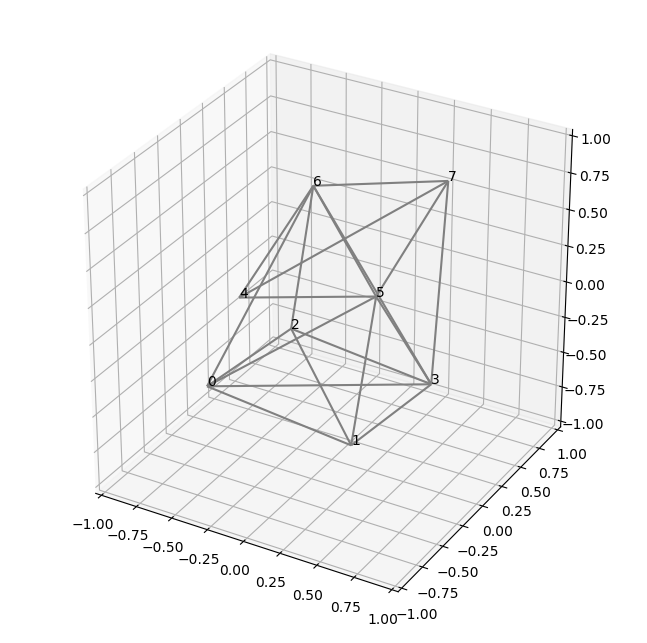

9
[array([-0.41990034])]


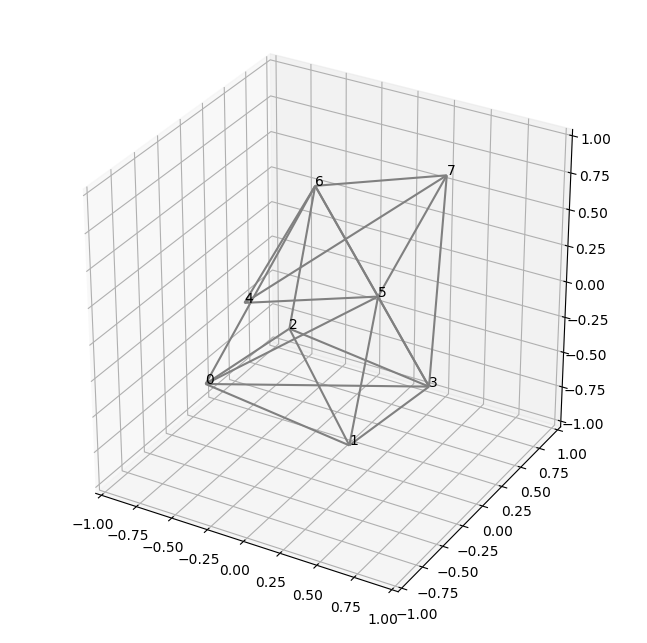

10
[array([-0.41990034])]


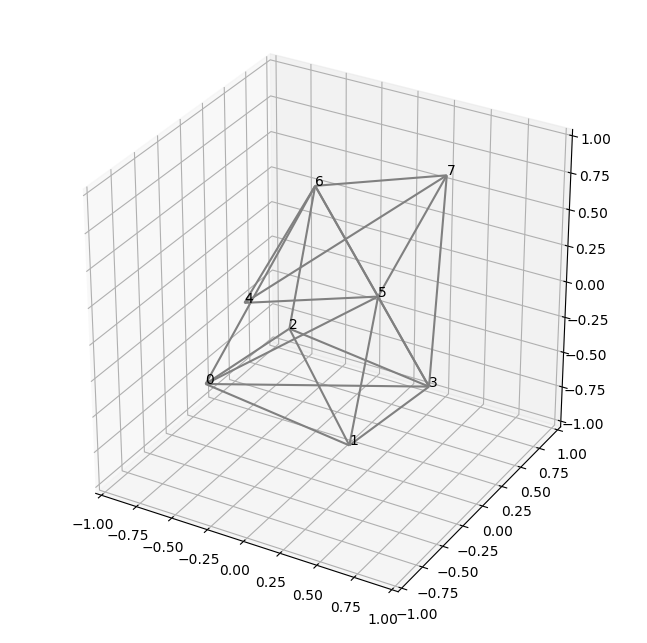

11
[array([-0.38098636])]


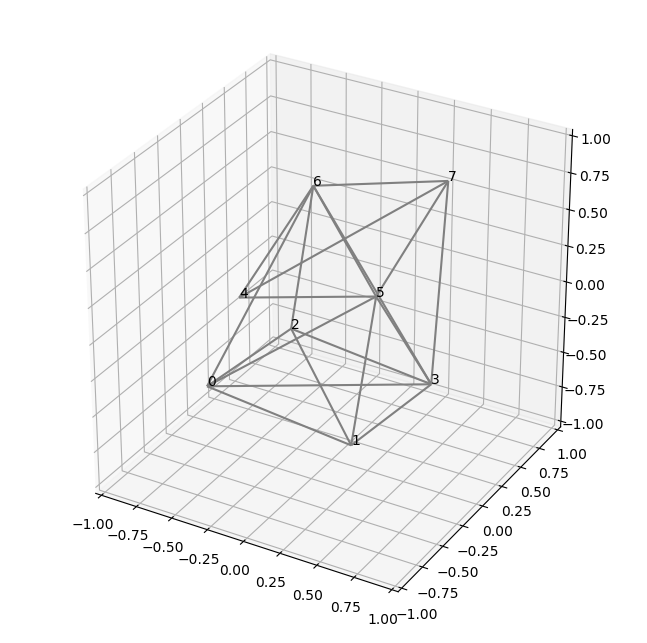

12
[array([-0.33382051])]


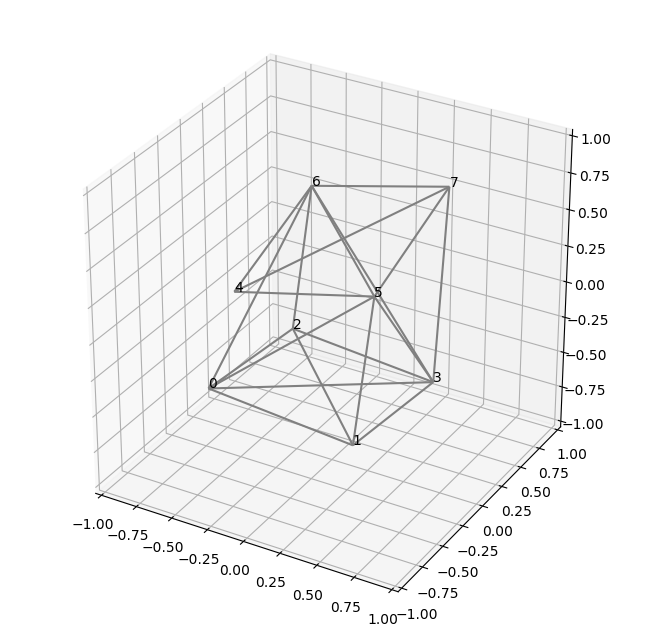

13
[array([-0.28850058])]


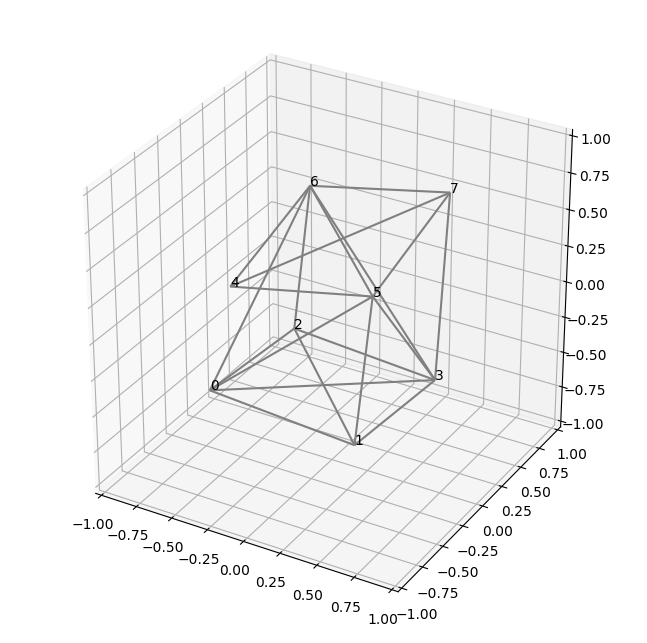

14
[array([-0.23455559])]


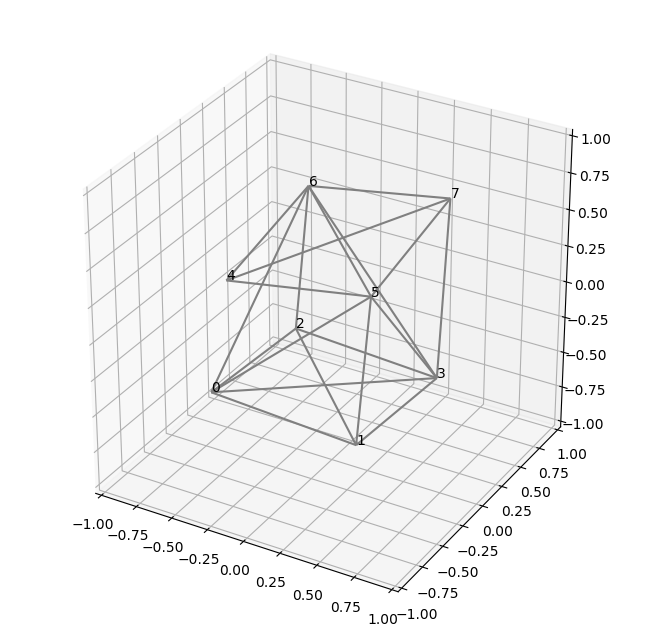

15
[array([-0.18119684])]


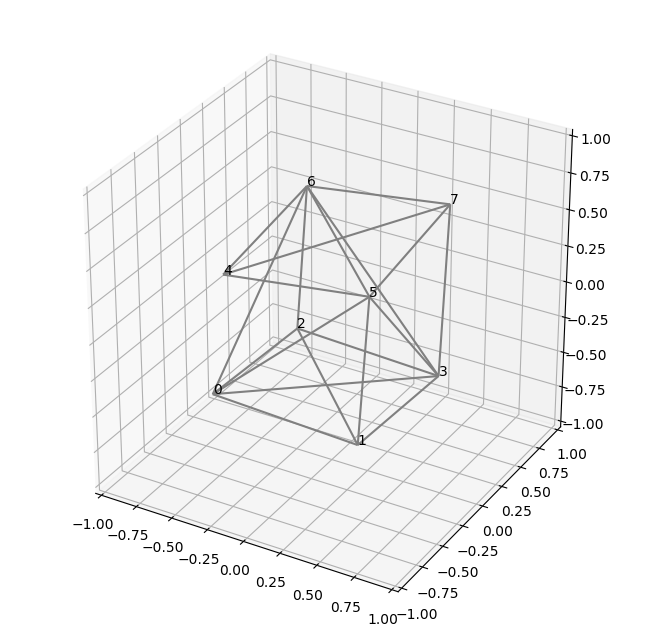

16
[array([-0.12982961])]


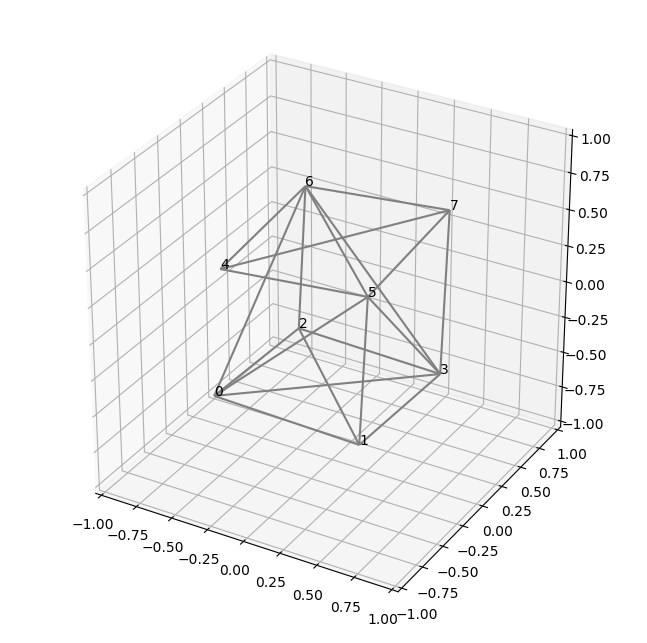

17
[array([-0.0820888])]


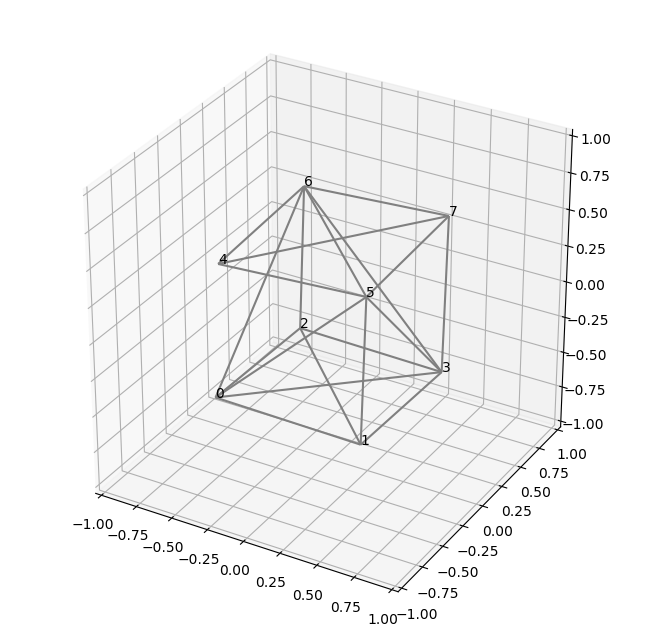

18
[array([-0.03311932])]


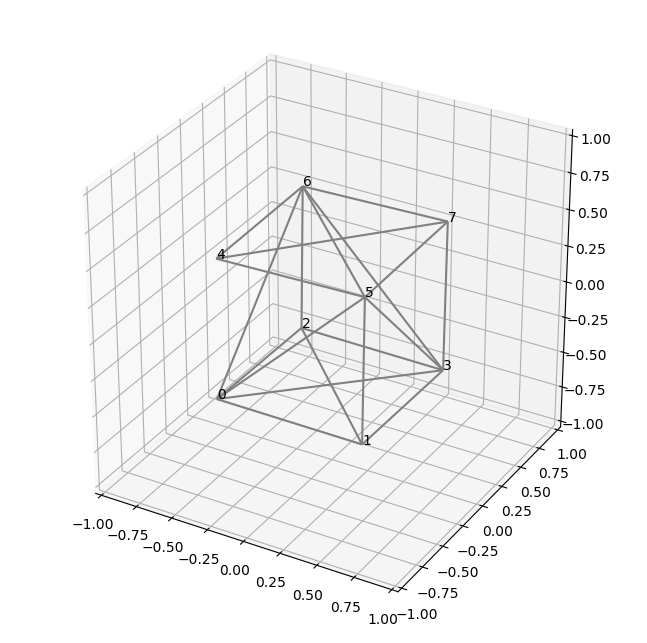

19
[array([ 0.])]


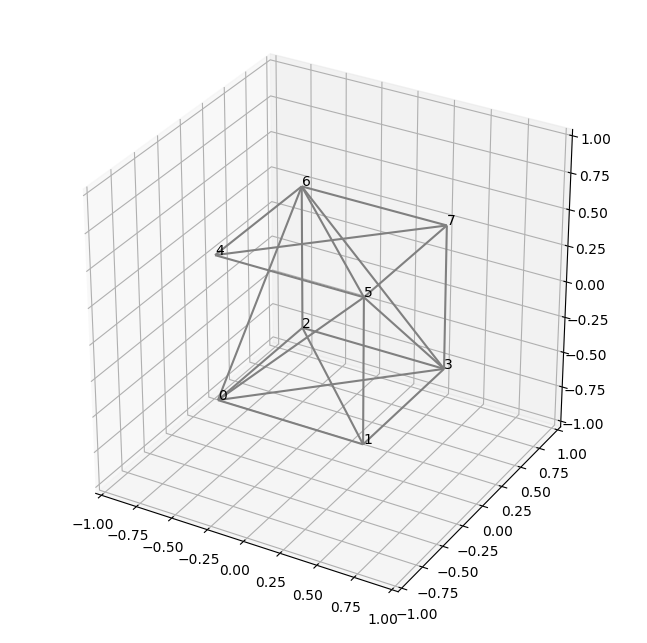

[0.0, 0.0005894305108257972, 0.003505234300192692, 0.009125701547452486, 0.017550953815945035, 0.028833492259328214, 0.04300662707600499, 0.060093727644929554, 0.08011225179355354, 0.10307583413764225, 0.10307583413764225, 0.08011225179355354, 0.06009372734823176, 0.04300662717520823, 0.028833492259328214, 0.017550953815945035, 0.00912570155575235, 0.0035052343138122373, 0.0005894305405384654, 0.0]


In [49]:
# K = result['K']

K = np.zeros(net.NE, float)
K[0] = K_init[0]
K[1] = K_init[1]
K[2] = K_init[2]
K[4] = K_init[4]
K[5] = K_init[5]
K[7] = K_init[7]
K[8] = K_init[8]
K[10] = K_init[10]
K[13] = K_init[13]
K[16] = K_init[16]
K[19] = K_init[19]
K[20] = K_init[20]
K[21] = K_init[21]
K[22] = K_init[22]
K[23] = K_init[23]
K[24] = K_init[24]
K[25] = K_init[25]
K[26] = K_init[26]
K[27] = K_init[27]


tuner.solver.setIntStrengths(K)


styles = {}
for b in range(net.NE):
    if K[b] == 0.0:
        styles[b] = {'show': False}
#         styles[b] = {'color': 'red'}

t = 0

# mag = 0.3
mag = 1.0
nsteps = 10
alpha_list = np.concatenate([np.linspace(0, mag, nsteps), np.linspace(mag, 0, nsteps)])
# alpha_list = np.linspace(0, mag, nsteps)
print alpha_list

# os.system("rm figs/fig*.png")

energy = []

for i, alpha in enumerate(alpha_list):
    print i
        
    tuner.solver.setAmplitude(alpha)
    
    print tuner.solver.solveMeas()
    (disp, strain_tensor) = tuner.solver.solveDOF()
    energy.append(tuner.solver.solveEnergy(disp[t], t))
              
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
        
    plot3D(ax, net, disp[0], styles=styles)  
    
    plt.savefig("frames/fig_{:04d}.png".format(i))
    
    
    plt.show()
    
print energy

In [51]:
nplot.createGIF("frames/*.png", "{}.gif".format("test"))

In [57]:
for i in range(NN):
    pos = node_pos[DIM*i:DIM*i+DIM]
    print i, pos[0], pos[1], pos[2]
    
n = 0
for i in range(NE):
    if K[i] != 0:
        print n, 
    

0 0.0 0.0 0.0
1 1.0 0.0 0.0
2 0.0 1.0 0.0
3 1.0 1.0 0.0
4 0.0 0.0 1.0
5 1.0 0.0 1.0
6 0.0 1.0 1.0
7 1.0 1.0 1.0


In [ ]:
prin